# Putting It All Together: Your Own Incubator Digital Twin

For the past notebooks, you've been working your way to build your own complete digital twin:
1. [0-Pre-requisites](../0-Pre-requisites) taught you the basics and how to run a [rabbitmq](../0-Pre-requisites/3-RabbitMQ.ipynb) and [influxdb](../0-Pre-requisites/4-InfluxDB.ipynb) servers through [docker](../0-Pre-requisites/2-Docker.ipynb).
2. [1-Incubator-Service](../1-Incubator-Service) gave you three basic services that work on top of the existing [incubator emulator](../incubator_dt/software/startup/start_all_services.py).
3. [2-Controller-Modelling](../2-Controller-Modelling) was about how to create your own [controller for the incubator](../2-Controller-Modelling/2-IncubatorControllerService.ipynb) as a service.
4. [3-Physics-Modelling](../3-Physics-Modelling) focused on modelling the incubator dynamics using both [ordinary differential equations](../3-Physics-Modelling/2-ModellingIncubatorDynamics.ipynb) but also [machine learning](../3-Physics-Modelling/4-TrainingIncubatorNN.ipynb). These two approaches are complementary and you have deployed a [machine learned monitoring](../3-Physics-Modelling/5-NNBasedMonitoringService.ipynb) service.
5. [4-Calibration](../4-Calibration) was about [estimating the parameters](../4-Calibration/2-CalibratingIncubatorDynamics.ipynb) for for the incubator dynamics from a dataset.
6. [5-IncubatorPTEmulator](../5-IncubatorPTEmulator) was about deploying those dynamics to create your own incubator PT emulator.

In this notebook, you put all the pieces of the above puzzle together, to form a complete digital twin system that you can run on your laptop.

The complete system looks like this, using the [C4 notation](https://c4model.com/):

![alt text](dt_overview.svg)


In [4]:
# Check that all scripts are available from previous notebooks.
import os
import sys

# Get the current working directory.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '6-PuttingItAllTogether', 'Current directory is not 6-PuttingItAllTogether'

# Get the parent directory absolute path. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# Check that the various scripts are available.

path_to_chek = os.path.join(parent_dir, '1-Incubator-Service', 'average_service.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

path_to_chek = os.path.join(parent_dir, '1-Incubator-Service', 'moving_temperature_average_service.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

path_to_chek = os.path.join(parent_dir, '1-Incubator-Service', 'pt_configuration_service.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

path_to_chek = os.path.join(parent_dir, '2-Controller-Modelling', 'controller.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

path_to_chek = os.path.join(parent_dir, '3-Physics-Modelling', 'temperature_prediction_service.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

path_to_chek = os.path.join(parent_dir, '5-IncubatorPTEmulator', 'pt_emulator_service.py')
assert os.path.exists(path_to_chek), f'{path_to_chek} not found. Run the required notebooks in order.'

In [5]:
%%writefile start_influxdb_rabbitmq.py
# Configure python path to load incubator modules
import sys
import os

# Get the current working directory. Should be 6-PuttingItAllTogether
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '6-PuttingItAllTogether', 'Current directory is not 6-PuttingItAllTogether'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

# Append the same path to PYTHONPATH
os.environ['PYTHONPATH'] = os.pathsep.join([os.environ.get('PYTHONPATH', ''), incubator_dt_software_dir])

from startup.start_docker_influxdb import start_docker_influxdb
from startup.start_docker_rabbitmq import start_docker_rabbitmq

if __name__ == '__main__':
    start_docker_rabbitmq()
    start_docker_influxdb()


Writing start_influxdb_rabbitmq.py


Now you're ready to run everything together. You'll need to open several terminals, to make it easier to inspect the whole system in operation. Follow the steps:
1. Open a terminal in the current folder and run: `python start_influxdb_rabbitmq.py`
    You should see an output like:
    ```
    Searching for container with the name: rabbitmq-server
    Exception in attempt to kill container: 404 Client Error for http+docker://localnpipe/v1.47/containers/rabbitmq-server/json: Not Found ("No such container: rabbitmq-server")
    Log will be stored in: C:\work\github\Example_Digital-Twin_Incubator\software\startup\logs\rabbitmq.log
    Running docker-compose command: docker compose up --detach --build
    Container rabbitmq-server  Creating
    Container rabbitmq-server  Created
    Container rabbitmq-server  Starting
    Container rabbitmq-server  Started
    docker-compose successful.
    Service is not ready yet. Attempts remaining:9
    ...
    Service is not ready yet. Attempts remaining:4
    RabbitMQ ready: ...
    Service is ready
    Searching for container with the name: influxdb-server
    Exception in attempt to kill container: 404 Client Error for http+docker://localnpipe/v1.47/containers/influxdb-server/json: Not Found ("No such container: influxdb-server")
    Log will be stored in: C:\work\github\Example_Digital-Twin_Incubator\software\startup\logs\influxdb.log
    Running docker-compose command: docker compose up --detach --build
    Network influxdbserver_default  Creating
    Network influxdbserver_default  Created
    Container influxdb-server  Creating
    Container influxdb-server  Created
    Container influxdb-server  Starting
    Container influxdb-server  Started
    docker-compose successful.
    Service is not ready yet. Attempts remaining:9
    ...
    InfluxDB ready:
    {"name":"influxdb", "message":"ready for queries and writes", "status":"pass", "checks":[], "version": "2.0.3", "commit": "fe04d346df"}

    Service is ready

    Process finished with exit code 0
    ```
2. Open a terminal in [5-IncubatorPTEmulator](../5-IncubatorPTEmulator) and run: `python incubator_data_recorder_influx.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\5-IncubatorPTEmulator> python .\incubator_data_recorder_influx.py
    2024-12-19 03:47:06.972 DEBUG RabbitMQClass : Connected.
    2024-12-19 03:47:06.978 INFO RabbitMQClass : Bound incubator.record.#--> amq.gen-7AB10Y3zop0vgNlzXKHJBg
    ```
3. Open a terminal in [5-IncubatorPTEmulator](../5-IncubatorPTEmulator) and run: `python pt_emulator_service.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\5-IncubatorPTEmulator> python .\pt_emulator_service.py
    2024-12-19 03:48:26.737 DEBUG RabbitMQClass : Connected.
    2024-12-19 03:48:26.745 INFO RabbitMQClass : Bound incubator.hardware.gpio.heater.on--> amq.gen-aQgiTtj0pjvYpZNpaqLp7Q
    2024-12-19 03:48:26.746 DEBUG RabbitMQClass : Received message is None None None
    2024-12-19 03:48:26.750 DEBUG RabbitMQClass : Message sent to incubator.record.driver.state.
    2024-12-19 03:48:26.750 DEBUG RabbitMQClass : {'measurement': 'emulator', 'time': 1734576506750862500, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.915871174281246, 'time_t1': 1734576506750862500, 't2': 29.915871174281246, 'time_t2': 1734576506750862500, 't3': 20.0, 'time_t3': 1734576506750862500, 'average_temperature': 29.915871174281246, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.004000186920166016}}
    2024-12-19 03:48:29.749 DEBUG RabbitMQClass : Received message is None None None
    2024-12-19 03:48:29.749 DEBUG RabbitMQClass : Message sent to incubator.record.driver.state.
    2024-12-19 03:48:29.749 DEBUG RabbitMQClass : {'measurement': 'emulator', 'time': 1734576509749869100, 'tags': {'source': 'emulator'}, 'fields': {'t1': 29.834405164458264, 'time_t1': 1734576509749869100, 't2': 29.834405164458264, 'time_t2': 1734576509749869100, 't3': 20.0, 'time_t3': 1734576509749869100, 'average_temperature': 29.834405164458264, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.002080678939819336}}
    ```
4. Open a terminal in [2-Controller-Modelling](../2-Controller-Modelling) and run: `python controller.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\2-Controller-Modelling> python controller.py
    2024-12-19 03:50:34.182 DEBUG RabbitMQClass : Connected.
    2024-12-19 03:50:34.188 DEBUG ControllerService : Stopping Fan
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.fan.on.
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : {'fan': False}
    2024-12-19 03:50:34.189 DEBUG ControllerService : Stopping Heater
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.heater.on.
    2024-12-19 03:50:34.189 DEBUG RabbitMQClass : {'heater': False}
    2024-12-19 03:50:34.240 INFO RabbitMQClass : Bound incubator.update.dtcourse.controller.parameters--> amq.gen-5favhmOS8sWru8yd1NOdVQ
    2024-12-19 03:50:34.245 INFO RabbitMQClass : Bound incubator.record.driver.state--> amq.gen-wZexHnF8iE8uj4sbu5IOfg
    Thermostat FMU instantiated with initial state.
    FMU experiment setup: Start Time = 0, Stop Time = -1
    Thermostat FMU entered initialization mode.
    Thermostat FMU exited initialization mode.
    2024-12-19 03:50:34.246 INFO ControllerService : Controller setup complete.
    2024-12-19 03:50:35.853 DEBUG ControllerService : Controller step
    Time: 1734576638.79s, State: Heating, Temp: 27.80°C
    2024-12-19 03:50:35.855 DEBUG ControllerService : Controller step done. Time(ns): 1734576635793186600, Heater: True, Fan: True, Temp: 27.795440305728917, State: Heating
    2024-12-19 03:50:35.856 DEBUG RabbitMQClass : Message sent to incubator.record.dtcourse.controller.state.
    2024-12-19 03:50:35.856 DEBUG RabbitMQClass : {'measurement': 'dtcourse_controller', 'time': 1734576635793186600, 'tags': {'source': 'dtcourse_controller'}, 'fields': {'plant_time': 1734576635793186600, 'heater_on': 1, 'fan_on': 1, 'current_state': 'Heating', 'max_temperature': 39.0, 'min_temperature': 36.0}}
    2024-12-19 03:50:35.856 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.heater.on.
    2024-12-19 03:50:35.857 DEBUG RabbitMQClass : {'heater': True}
    2024-12-19 03:50:35.857 DEBUG RabbitMQClass : Message sent to incubator.hardware.gpio.fan.on.
    2024-12-19 03:50:35.858 DEBUG RabbitMQClass : {'fan': True}
    ```
5. At this stage you have the PT working, and data being recorded to the time series DB. Check in the DB management page that this is the case.
    You should be able to query the data and see the following:

    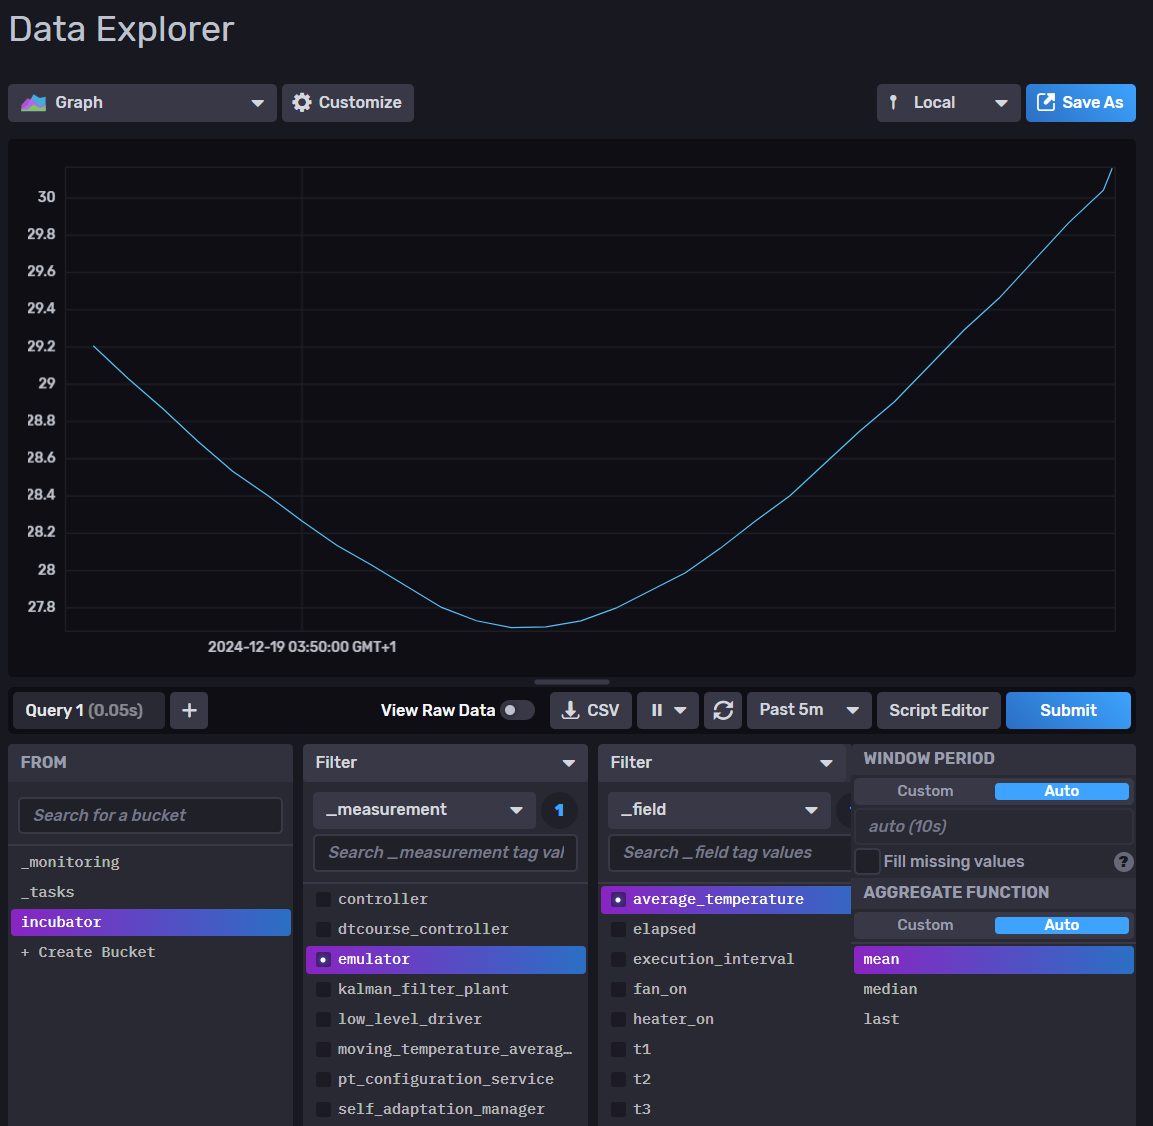

6. Open a terminal in [1-Incubator-Service](../1-Incubator-Service) and run: `python average_service.py`
    You should see no errors:
    ```
    PS C:\work\github\IncubatorDTCourse\1-Incubator-Service> python average_service.py

    ```
7. Open a terminal in [1-Incubator-Service](../1-Incubator-Service) and run: `python moving_temperature_average_service.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\1-Incubator-Service> python moving_temperature_average_service.py
    2024-12-19 03:58:05.707 DEBUG RPCClient : Connected.
    2024-12-19 03:58:05.967 DEBUG RPCClient : Message sent to incubator.dtcourse.average_service.
    2024-12-19 03:58:05.967 DEBUG RPCClient : {'method': 'compute_average', 'args': {'values': [34.891714858956]}}
    2024-12-19 03:58:06.018 DEBUG RPCClient : Message received: method=<Basic.Deliver(['consumer_tag=ctag1.c55fffd558e0495aaa22704604dafe21', 'delivery_tag=1', 'exchange=', 'redelivered=False', 'routing_key=amq.gen-nRxZSDQz_-ONABM8KEGQsw'])>; properties=<BasicProperties(['correlation_id=a4a88d6b-2cfc-4b91-bfd7-639e117118df'])>. Body:
    b'{"average": 34.891714858956}'
    2024-12-19 03:58:08.956 DEBUG RPCClient : Message sent to incubator.dtcourse.average_service.
    2024-12-19 03:58:08.957 DEBUG RPCClient : {'method': 'compute_average', 'args': {'values': [34.891714858956, 34.9416524533522]}}
    2024-12-19 03:58:09.009 DEBUG RPCClient : Message received: method=<Basic.Deliver(['consumer_tag=ctag1.c55fffd558e0495aaa22704604dafe21', 'delivery_tag=2', 'exchange=', 'redelivered=False', 'routing_key=amq.gen-nRxZSDQz_-ONABM8KEGQsw'])>; properties=<BasicProperties(['correlation_id=773df523-851d-41d7-bb5d-560e15290bce'])>. Body:
    b'{"average": 34.9166836561541}'
    2024-12-19 03:58:11.955 DEBUG RPCClient : Message sent to incubator.dtcourse.average_service.
    2024-12-19 03:58:11.956 DEBUG RPCClient : {'method': 'compute_average', 'args': {'values': [34.891714858956, 34.9416524533522, 34.991445081079654]}}
    ```
8. Open a terminal in [1-Incubator-Service](../1-Incubator-Service) and run: `python pt_configuration_service.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\1-Incubator-Service> python pt_configuration_service.py
    2024-12-19 04:00:12.840 DEBUG RabbitMQClass : Connected.
    2024-12-19 04:00:12.847 INFO RabbitMQClass : Bound incubator.record.driver.state--> amq.gen-ny3O3-H1b2i5tbL37zGsxQ
    2024-12-19 04:00:12.852 INFO RabbitMQClass : Bound incubator.record.dtcourse.moving_temperature_average_service.temperature_moving_average--> amq.gen-cxQKtyo2FVThsBVm5v2yfw
    2024-12-19 04:00:17.991 DEBUG RabbitMQClass : Message sent to incubator.record.dtcourse.pt_configuration_service.temperature_moving_average.
    2024-12-19 04:00:17.991 DEBUG RabbitMQClass : {'measurement': 'pt_configuration_service', 'time': 1734577214948172100, 'tags': {'source': 'pt_configuration_service'}, 'fields': {'difference': 0.20005858191466785}}
    2024-12-19 04:00:24.001 DEBUG RabbitMQClass : Message sent to incubator.record.dtcourse.pt_configuration_service.temperature_moving_average.
    ```
9. Open a terminal in [3-Physics-Modelling](../3-Physics-Modelling) and run: `python temperature_prediction_service.py`
    You should see:
    ```
    PS C:\work\github\IncubatorDTCourse\3-Physics-Modelling> python temperature_prediction_service.py
    2024-12-1`9 04:02:10.493 DEBUG RabbitMQClass : Connected.
    2024-12-19 04:02:10.503 INFO RabbitMQClass : Bound incubator.record.driver.state--> amq.gen-qR_3tzQbOlZY2rgd-pMFCg
    2024-12-19 04:02:15.053 DEBUG RabbitMQClass : Message sent to incubator.record.dtcourse.temperature_prediction_service.average_temperature.
    2024-12-19 04:02:15.053 DEBUG RabbitMQClass : {'measurement': 'temperature_prediction_service', 'time': 1734577334977766100, 'tags': {'source': 'temperature_prediction_service'}, 'fields': {'prediction_error': -0.07561482531203723, 'average_temperature': 38.64737319946289}}
    2024-12-19 04:02:18.025 DEBUG RabbitMQClass : Message sent to incubator.record.dtcourse.temperature_prediction_service.average_temperature.
    2024-12-19 04:02:18.025 DEBUG RabbitMQClass : {'measurement': 'temperature_prediction_service', 'time': 1734577337980715500, 'tags': {'source': 'temperature_prediction_service'}, 'fields': {'prediction_error': -0.07567478481837497, 'average_temperature': 38.686439514160156}}`
    ```
10. Now everything is working, and you can see the data on the time series db management page. You can import the dashboard configuration [incubatordtcourselit.json](incubatordtcourselit.json) provided, to get a dashboard like the following:

    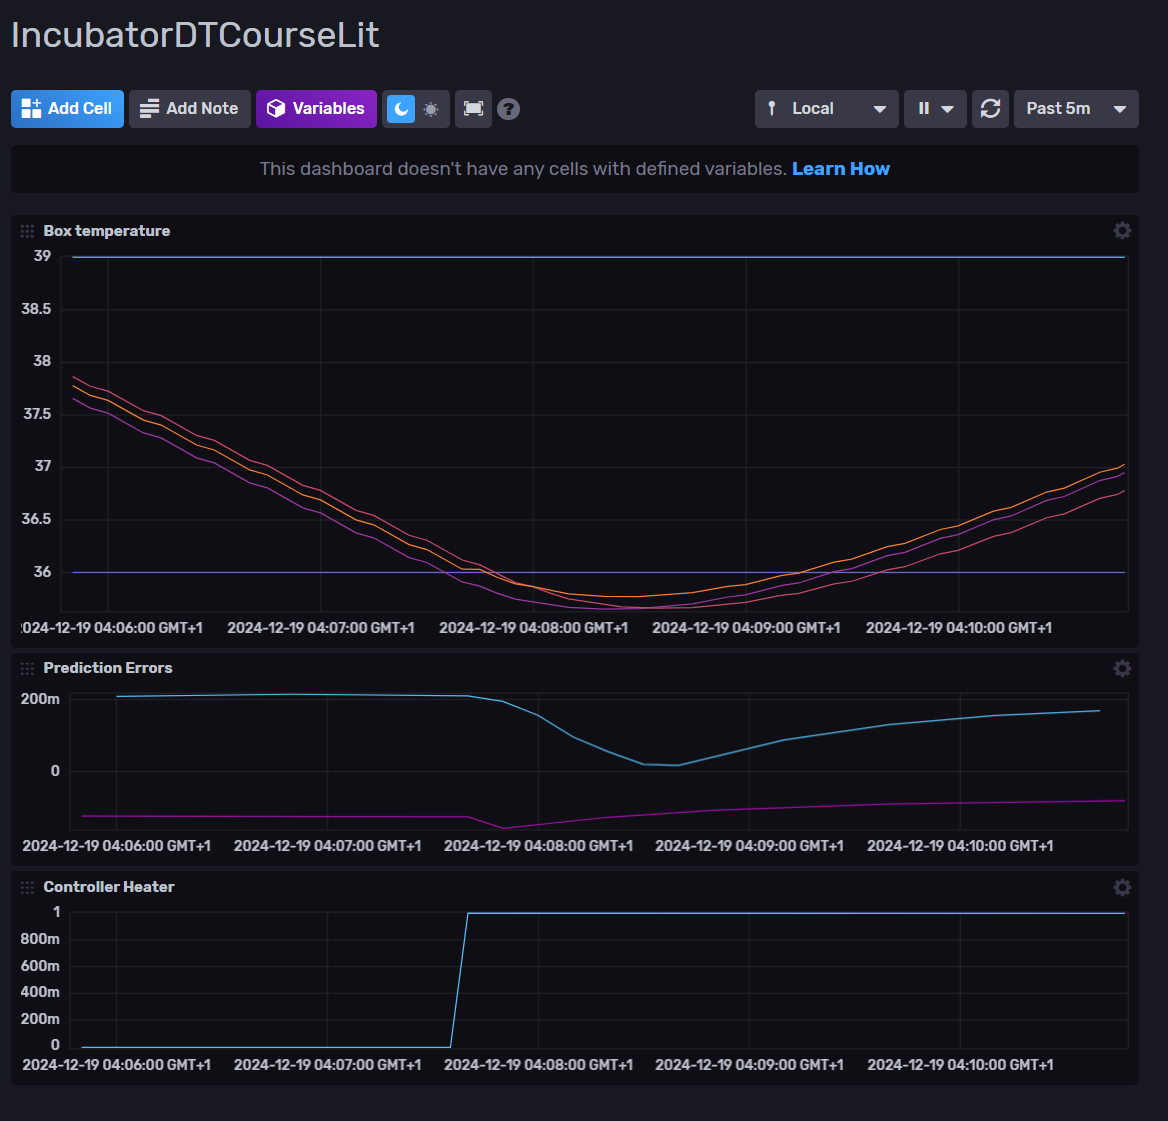


**Congratulations**. From here onward, with a few exceptions, you will be able to develop your own DT services for the incubator and other systems!

## Exercises

1. Adjust the [PTReconfigurationService](../1-Incubator-Service/pt_configuration_service.py) so that it sends the correct message to your [controller](../2-Controller-Modelling/controller.py) setting a lower max and min temperatures when an anomaly is detected. Send a message to the [PTEmulatorService](../5-IncubatorPTEmulator/pt_emulator_service.py) to simulate opening the lid and observe that the PTReconfigurationService reacts accordingly.
2. Adjust the [PTReconfigurationService](../1-Incubator-Service/pt_configuration_service.py) so that it receives messages from the [NNBasedMonitoringService](../3-Physics-Modelling/temperature_prediction_service.py) instead of from the [MovingAverageTemperatureService](../1-Incubator-Service/moving_temperature_average_service.py).